# Information Extraction via text-to-text method.

Adverse drug events and medication extraction:  The origin of the problem:
* https://n2c2.dbmi.hms.harvard.edu/2022-track-1

* https://pubmed.ncbi.nlm.nih.gov/31584655/

In [ ]:
import pandas as pd
train=pd.read_parquet("train.parquet")
test_without_label=pd.read_parquet("test_without_label.parquet")

In [ ]:
train.head()

,text,answer
598,7. Metoprolol Tartrate 25 mg Tablet Sig: Three...,Drug:Metoprolol Tartrate / Route:PO / Strength...
357,She was not on aspirin or coumadin because of ...,Drug:aspirin;coumadin /
888,3. docusate sodium 100 mg Capsule Sig: One (1)...,Drug:docusate sodium / Route:PO / Reason:const...
3814,- TITRATE UP GABAPENTIN FOR ZOSTER PAIN. . # H...,Drug:GABAPENTIN;furosemide / Reason:ZOSTER PAI...
1721,He was given Narcan 400 mcg IM and Flumazanil ...,Drug:Narcan;Flumazanil / Route:IM;IV / Strengt...


In [ ]:
train.answer.apply(lambda x: [e.split(":")[0] for e in x.split("/")])

598     [Drug,  Route,  Strength,  Frequency,  Dosage,...
357                                             [Drug,  ]
888     [Drug,  Route,  Reason,  Strength,  Frequency,...
3814                                   [Drug,  Reason,  ]
1721                         [Drug,  Route,  Strength,  ]
                              ...                        
4313    [Drug,  Route,  Reason,  Strength,  Frequency,...
2490                                            [Drug,  ]
1914                                          [Dosage,  ]
5340    [Drug,  Route,  Strength,  Frequency,  Dosage,...
4506    [Drug,  Route,  Reason,  Strength, mL;50 mg , ...
Name: answer, Length: 4306, dtype: object

In [ ]:
train.head(1)

,text,answer
598,7. Metoprolol Tartrate 25 mg Tablet Sig: Three...,Drug:Metoprolol Tartrate / Route:PO / Strength...


In [ ]:
train.shape

(4306, 2)

In [ ]:
test_without_label.head()

,Unnamed: 0,text,answer
0,4159,Has failed trials of enbrel and methotrexate d...,NaN
1,4617,"7. Multivitamin Oral 8. Aspirin 81 mg Tablet,...",NaN
2,1687,His HR did not respond to Diltiazem drip or mu...,NaN
3,3468,Evaluated by neurosurgery who would not interv...,NaN
4,126,He was on a bowel regimen of Colace and Dulcol...,NaN


In [ ]:
len(test_without_label)

1436

# Train your code

* Train your code with train.parquet
* Predict the answer column in test test_without_label.parquet
* Answer is a list of entity prediction seperated by "/" .
* Each block has *label:name* format
* For instance. Bold names are labels, others are expressions

**Drug**:Metoprolol Tartrate / **Route**:PO / **Strength**:25 mg / **Frequency**:BID / **Form**:Tablet

#Train Dataset Exploration and Transformation

In [ ]:
data=train.copy()

In [ ]:
#initial labels
labels= ['Drug', 'Route', 'Strength', 'Frequency', 'Form', 'Duration']

In [ ]:
answers=data.answer

In [ ]:
entity_list=train.answer.apply(lambda x: [e for e in x.split("/")])

In [ ]:
def list_to_dict(kv_list):
    kv_dict = {}
    for pair in kv_list:
        if ':' in pair:
            key, value = pair.split(':', 1)
            kv_dict[key.strip()] = value.strip()
    return kv_dict

In [ ]:
train['Transformed_answer'] = train['answer'].apply(lambda x: list_to_dict([e for e in x.split("/")]))

In [ ]:
train.head()

,text,answer,Transformed_answer
598,7. Metoprolol Tartrate 25 mg Tablet Sig: Three...,Drug:Metoprolol Tartrate / Route:PO / Strength...,"{'Drug': 'Metoprolol Tartrate', 'Route': 'PO',..."
357,She was not on aspirin or coumadin because of ...,Drug:aspirin;coumadin /,{'Drug': 'aspirin;coumadin'}
888,3. docusate sodium 100 mg Capsule Sig: One (1)...,Drug:docusate sodium / Route:PO / Reason:const...,"{'Drug': 'docusate sodium', 'Route': 'PO', 'Re..."
3814,- TITRATE UP GABAPENTIN FOR ZOSTER PAIN. . # H...,Drug:GABAPENTIN;furosemide / Reason:ZOSTER PAI...,"{'Drug': 'GABAPENTIN;furosemide', 'Reason': 'Z..."
1721,He was given Narcan 400 mcg IM and Flumazanil ...,Drug:Narcan;Flumazanil / Route:IM;IV / Strengt...,"{'Drug': 'Narcan;Flumazanil', 'Route': 'IM;IV'..."


#NER using SPACY


1.   We will incorporate a pretrained SPACY model trained on medical dataset to get the annotations.
2.   Plug in the annotations in the training phase of SPACY for NER.
3.   Make the predictions on the test dataset.



## Citing Pretrained Model (Layer 1):
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz


 https://huggingface.co/kormilitzin/en_core_med7_trf/resolve/main/en_core_med7_trf-any-py3-none-any.whl


https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl

In [ ]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

In [ ]:
!pip install https://huggingface.co/kormilitzin/en_core_med7_trf/resolve/main/en_core_med7_trf-any-py3-none-any.whl
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl

### Loading the model to extract the annotations on the train dataset

In [ ]:
nlp = spacy.load("en_core_med7_lg")

def generate_annotation(texts):
    annotations = []
    for text in texts:
        doc = nlp(text)
        entities = []
        for ent in doc.ents:
            entities.append((ent.start_char, ent.end_char, ent.label_))
        annotations.append((text, {'entities': entities}))
    return annotations

In [ ]:
medical_doc = train['text'].tolist()

annotations = generate_annotation(medical_doc)

# sample of text and its corresponding annotations
print("Document:")
print(annotations[0][0]) # first row text
print("Annotations:")
print(annotations[0][1]) # annotation for the first row text

Document:
7. Metoprolol Tartrate 25 mg Tablet Sig: Three (3) Tablet PO BID (2 times a day). 
Annotations:
{'entities': [(3, 22, 'DRUG'), (23, 28, 'STRENGTH'), (29, 35, 'FORM'), (41, 50, 'DOSAGE'), (51, 57, 'FORM'), (58, 60, 'ROUTE')]}


In [ ]:
annotations[0][1]

{'entities': [(3, 22, 'DRUG'),
  (23, 28, 'STRENGTH'),
  (29, 35, 'FORM'),
  (41, 50, 'DOSAGE'),
  (51, 57, 'FORM'),
  (58, 60, 'ROUTE')]}

We can see here:
{'entities': [(3, 22, 'DRUG'),
  (23, 28, 'STRENGTH'),
  (29, 35, 'FORM'),
  (41, 50, 'DOSAGE'),
  (51, 57, 'FORM'),
  (58, 60, 'ROUTE')]}


In [ ]:
# we will display the NER in the text using the displacy method.
from spacy import displacy
nlp = spacy.load("en_core_med7_lg")


#creating some colors
col_dict = {}
s_colours = ['#e6194B', '#3cb44b', '#ffe119', '#ffd8b1', '#f58231', '#f032e6', '#42d4f4']
for label, colour in zip(nlp.pipe_labels['ner'], s_colours):
    col_dict[label] = colour

options = {'ents': nlp.pipe_labels['ner'], 'colors':col_dict}
transcription = train['text'][0]
doc = nlp(transcription)

spacy.displacy.render(doc, style = 'ent', jupyter = True, options = options)

[(ent.text, ent.label_) for ent in doc.ents]

[('antibiotics', 'DRUG')]

In [ ]:
#loading spacy.load("en_ner_bc5cdr_md") that can identify the entity type.
nlp = spacy.load("en_ner_bc5cdr_md")
transcription = train['text'].iloc[1]
doc= nlp(transcription)

# Entities in a sample text
for ent in doc.ents:
    print(f"Text: {ent.text}, Entity Type: {ent.label_}")


Text: aspirin, Entity Type: CHEMICAL


In [ ]:
#this spacy model nlp = spacy.load("en_core_med7_lg")
# can catch some patterns.
from  spacy.matcher import Matcher

# Let's load the model
nlp = spacy.load("en_core_med7_lg")

# Patterns for DRUG DOSAGE.
patterns = [
    [{"ENT_TYPE": "DRUG"}, {"LIKE_NUM": True}, {"IS_ASCII": True}],
    [{"LOWER": {"IN": ["mg", "g", "ml"]}}, {"ENT_TYPE": "DRUG"}],
    [{"ENT_TYPE": "DRUG"}, {"IS_DIGIT": True, "OP": "?"}, {"LOWER": {"IN": ["mg", "g", "ml"]}}]
]

matcher = Matcher(nlp.vocab)
matcher.add("DRUG_DOSE", patterns)

for transcription in  train['text']:
    doc = nlp(transcription)
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]
        span = doc[start:end]
        print(string_id, start, end, span.text)

In [ ]:
nlp = spacy.load("en_core_med7_lg")
 # extracting keywords from the text.
 # however, we already preidentifed the keywords
def extract_keywords(text):
    doc = nlp(text)
    entities = []
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities


In [ ]:
# Lets define our Labels
medical_keywords = ['Drug', 'Route', 'Strength', 'Frequency', 'Form', 'Duration', 'Reason', 'ADE']

medical_doc = train['text']
for transcription in medical_doc:
    entities = extract_keywords(transcription.lower())

In [ ]:
all_entities = []
#consolidating the entities
for transcription in train['text']:
    entities = extract_keywords(transcription.lower())

    all_entities.append(entities)

print(all_entities)

[[('metoprolol tartrate', 'DRUG'), ('25 mg', 'STRENGTH'), ('tablet', 'FORM'), ('three (3)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('bid', 'FREQUENCY')], [('aspirin', 'DRUG'), ('coumadin', 'DRUG')], [('docusate sodium', 'DRUG'), ('100 mg', 'STRENGTH'), ('capsule', 'FORM'), ('one (1)', 'DOSAGE'), ('capsule', 'FORM'), ('po', 'ROUTE')], [('gabapentin', 'DRUG'), ('furosemide', 'DRUG')], [('narcan', 'DRUG'), ('400 mcg', 'STRENGTH'), ('flumazanil', 'DRUG'), ('200 mg', 'STRENGTH'), ('iv', 'ROUTE')], [('1', 'DOSAGE'), ('warfarin', 'DRUG'), ('5 mg', 'STRENGTH'), ('tablet', 'FORM'), ('one (1)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('once daily', 'FREQUENCY'), ('amlodipine', 'DRUG'), ('5 mg', 'STRENGTH'), ('tablet', 'FORM'), ('one (1)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('daily (daily)', 'FREQUENCY'), ('guaifenesin', 'DRUG'), ('syrup', 'FORM'), ('po', 'ROUTE'), ('lisinopril', 'DRUG'), ('20 mg', 'STRENGTH'), ('tablet', 'FORM'), ('two (2)', 'DOSAGE'), ('tablet', 'F

SAMPLE of the extracted entities on the train dataset: ('po', 'ROUTE'), ('aspirin', 'DRUG'), ('325 mg', 'STRENGTH'), ('tablet', 'FORM'), ('one (1)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('daily (daily)', 'FREQUENCY'), ('atorvastatin', 'DRUG'), ('80 mg', 'STRENGTH'), ('tablet', 'FORM'), ('one (1)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('daily (daily)', 'FREQUENCY'), ('senna', 'DRUG'), ('8.6 mg', 'STRENGTH'), ('tablet', 'FORM'), ('one (1)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('bid', 'FREQUENCY'), ('disk with device', 'FORM'), ('inhalation', 'ROUTE'), ('twice a day', 'FREQUENCY'), ('prednisone', 'DRUG'), ('10 mg', 'STRENGTH'), ('tablet', 'FORM'), ('1/2-4', 'DOSAGE'), ('tablets', 'FORM'), ('po', 'ROUTE'), ('once a day', 'FREQUENCY'), ('for 14 days', 'DURATION'), ('4', 'DOSAGE'), ('tabs', 'FORM'), ('for 1 day', 'DURATION'), ('2', 'DOSAGE'), ('tabs', 'FORM'), ('for 4 days', 'DURATION'), ('1', 'DOSAGE'), ('tab', 'FORM'), ('for 4 days', 'DURATION'), ('tab', 'FORM'), ('for 4 days', 'DURATION')], [('docusate sodium', 'DRUG'), ('100 mg', 'STRENGTH'), ('capsule', 'FORM'), ('one (1)', 'DOSAGE'), ('capsule', 'FORM'), ('po', 'ROUTE'), ('claritin', 'DRUG'), ('10 mg', 'STRENGTH'), ('tablet', 'FORM'), ('one (1)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('once a day', 'FREQUENCY'), ('100 mg', 'STRENGTH'), ('capsule', 'FORM'), ('one (1)', 'DOSAGE'), ('capsule', 'FORM'), ('po', 'ROUTE'), ('aspirin', 'DRUG'), ('81 mg', 'STRENGTH'), ('tablet', 'FORM'), ('one (1)', 'DOSAGE'), ('po', 'ROUTE'), ('daily (daily)', 'FREQUENCY'), ('atorvastatin', 'DRUG'), ('20 mg', 'STRENGTH'), ('tablet', 'FORM'), ('one (1)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('daily (daily)', 'FREQUENCY'), ('amiodarone', 'DRUG'), ('200 mg', 'STRENGTH'), ('tablet', 'FORM'), ('two (2)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('bid', 'FREQUENCY'), ('metoprolol tartrate', 'DRUG'), ('50 mg', 'STRENGTH'), ('tablet', 'FORM'), ('one (1)', 'DOSAGE'), ('tablet', 'FORM'), ('po', 'ROUTE'), ('bid', 'FREQUENCY'), ('spironolactone', 'DRUG'), ('25 mg', 'STRENGTH')

##Named Entity Recognition Model Using SPACY






In [ ]:
import spacy
import random
from spacy.training.example import Example

In [ ]:
TRAIN_DATA = []
for text, annot in annotations:
    entities = []
    for start, end, label in annot['entities']:
        entities.append((start, end, label))
    TRAIN_DATA.append((text, {'entities': entities}))

In [ ]:
nlp = spacy.blank('en')

In [ ]:
ner = nlp.add_pipe('ner', last=True)

In [ ]:
for _, annotations in TRAIN_DATA:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

In [ ]:
pipe_exceptions = ['ner']
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

###Training the SPACY NER Model using our Training Dataset

In [ ]:
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    for itn in range(10):
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in TRAIN_DATA:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], losses=losses, drop=0.5)
        print(losses)

{'ner': 18205.77438075389}
{'ner': 11162.62430860349}
{'ner': 9642.29267303208}
{'ner': 8603.881486216746}
{'ner': 7725.447135892118}
{'ner': 7146.873617672308}
{'ner': 6600.957857296375}
{'ner': 6238.957883078195}
{'ner': 5880.75099730373}
{'ner': 5570.960171257014}


{'ner': 18205.77438075389}
{'ner': 11162.62430860349}
{'ner': 9642.29267303208}
{'ner': 8603.881486216746}
{'ner': 7725.447135892118}
{'ner': 7146.873617672308}
{'ner': 6600.957857296375}
{'ner': 6238.957883078195}
{'ner': 5880.75099730373}
{'ner': 5570.960171257014}

In [ ]:
nlp.to_disk("ner_trained_spacy_model")

###Saving the trained SPACY model

In [ ]:
import shutil

# Directory containing the trained model
model_directory = "ner_trained_spacymodel"

shutil.make_archive(model_directory, 'zip', model_directory)


'/content/ner_trained_spacymodel.zip'

#Testing the trained model on the test dataset

In [ ]:
nlp = spacy.load("/content/ner_trained_spacy_model")

In [ ]:
for text in test_without_label['text']:

    doc = nlp(text)

    # Print the detected entities
    print("Entities in '{}':".format(text))
    for ent in doc.ents:
        print("Entity:", ent.text, ", Label:", ent.label_)
    print()

Streaming output truncated to the last 5000 lines.
Entity: TAB , Label: FORM
Entity: PO , Label: ROUTE
Entity: DAILY , Label: FREQUENCY
Entity: multivitamin , Label: DRUG
Entity: Daily , Label: FREQUENCY
Entity: 1 , Label: DOSAGE
Entity: by mouth , Label: ROUTE
Entity: daily , Label: FREQUENCY
Entity: 30 , Label: DOSAGE
Entity: OLANZapine , Label: DRUG
Entity: 15 mg , Label: STRENGTH
Entity: PO , Label: ROUTE
Entity: QPM , Label: FREQUENCY
Entity: olanzapine , Label: DRUG
Entity: 15 mg , Label: STRENGTH
Entity: 1 , Label: DOSAGE
Entity: by mouth , Label: ROUTE
Entity: at bedtime , Label: FREQUENCY
Entity: 30 , Label: DOSAGE
Entity: Omeprazole , Label: DRUG
Entity: 20 mg , Label: STRENGTH
Entity: PO , Label: ROUTE
Entity: DAILY , Label: FREQUENCY
Entity: omeprazole , Label: DRUG
Entity: 20 mg , Label: STRENGTH
Entity: 1 , Label: DOSAGE
Entity: by mouth , Label: ROUTE
Entity: daily , Label: FREQUENCY
Entity: 30 , Label: DOSAGE
Entity: Propranolol , Label: DRUG
Entity: 20 mg , Label: STRE

In [ ]:
def extract_entities(text):
    doc = nlp(text)
    entities_dict = {}
    for ent in doc.ents:
        entities_dict.setdefault(ent.label_, []).append(ent.text)
    return entities_dict

In [ ]:
entities_list = [extract_entities(text) for text in test_without_label['text']]


Transforming the answer column into a dictionary, to check the main keywords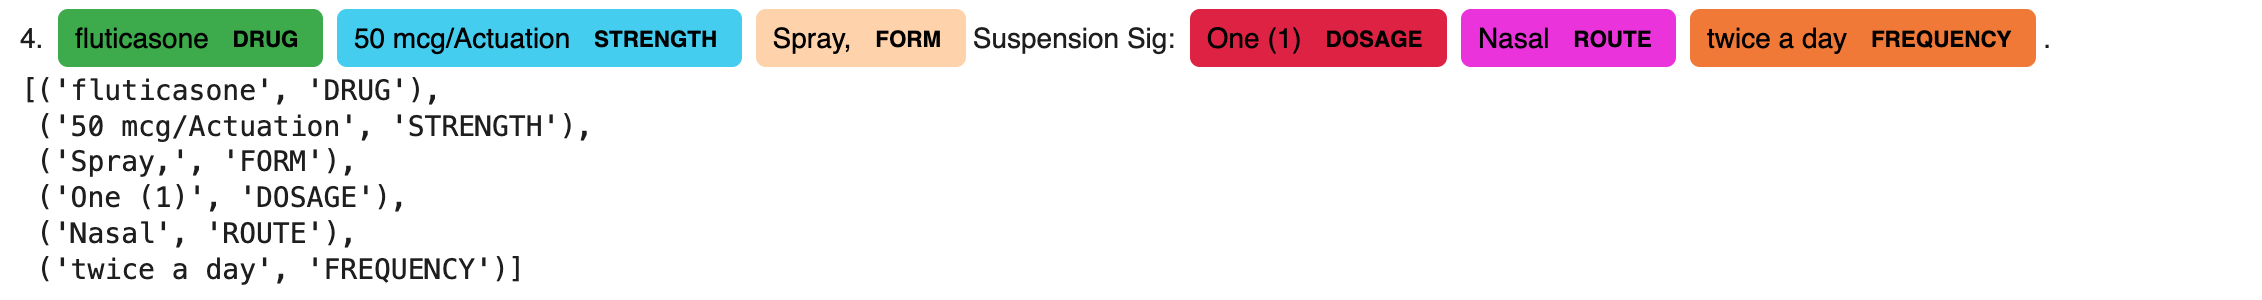

In [ ]:
test_without_label=test_without_label.drop(['predicted_entities'], axis=1)

In [ ]:
test_without_label['answer'] = entities_list

In [ ]:
test_without_label.head()

,Unnamed: 0,text,answer
0,4159,Has failed trials of enbrel and methotrexate d...,{'DRUG': ['enbrel']}
1,4617,"7. Multivitamin Oral 8. Aspirin 81 mg Tablet,...","{'DRUG': ['Multivitamin', 'Aspirin'], 'ROUTE':..."
2,1687,His HR did not respond to Diltiazem drip or mu...,"{'DRUG': ['Diltiazem', 'Diltiazem', 'Metoprolo..."
3,3468,Evaluated by neurosurgery who would not interv...,{'DRUG': ['antibiotics']}
4,126,He was on a bowel regimen of Colace and Dulcol...,"{'DRUG': ['Colace', 'Dulcolax']}"


In [ ]:
test_without_label.to_csv('test_with_entities_trained_spacy.csv', index=False)

In [ ]:
test_without_label.to_parquet('test_with_entities_trained_spacy.parquet')